In [1]:
import os
os.environ['PYTHONWARNINGS'] = "ignore"
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import pickle
import xgboost as xgb
import shap
from matplotlib.ticker import MaxNLocator,MultipleLocator
from scipy.stats import kendalltau
from scipy.special import expit

In [2]:
import numpy as np
print(np.__version__) #1.26.4
print(shap.__version__) #0.46.1.dev86
print(sklearn.__version__) #1.6.0
print(xgb.__version__) #1.7.6

2.0.2
0.46.1.dev86
1.5.2
2.1.3


## Preprocessing

In [3]:
# Use White alone & African American only 
FEAT_CNT = 8
STATE = 'NY'
FOLDS = 5


In [4]:
categorical_cols =['Occupation', 'Marriage','Place of Birth','Sex', 'Race']

with open(file=f'dataset/ACS_Income_{STATE}.pickle', mode='rb') as f:
    df=pickle.load(f)
df = df[(df['Race']=='White alone') | (df['Race']== 'Black or African American alone')]
df.reset_index(drop=True, inplace=True)
columns = df.columns
with pd.option_context('future.no_silent_downcasting', True):
    df.replace([' <=50K',' >50K'],
                 [0,1], inplace = True)
    df['Sex'].replace( {'Female':0.0},inplace = True)
    df['Sex'].replace({'Male':1.0}, inplace = True)
X = df.iloc[:, 0:FEAT_CNT]
Y = df.iloc[:, FEAT_CNT]

category_col =['Occupation', 'Marriage','Place of Birth', 'Race']
X = pd.get_dummies(X, columns=category_col, drop_first=True)
for c in X.columns:
    X[c] = X[c].astype(float)

In [5]:
np.random.seed(0)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

## Utils

In [6]:
def plot_frequency(values):
# Count the frequency of each unique value
    unique_values = sorted(set(values))
    counts = [values.count(v) for v in unique_values]
    
    # Plot histogram in bar format
    plt.bar(unique_values, counts, color='skyblue', alpha=0.7)
    
    # Set x-ticks on every integer but label only at intervals of 5
    plt.xticks(
        ticks=range(min(unique_values), max(unique_values) + 1),  # All integers
        labels=[
            str(v) if v % 5 == 2 else "" for v in range(min(unique_values), max(unique_values) + 1)
        ]  # Labels only at intervals of 5
    )
    # Plot histogram in bar format
    plt.bar(unique_values, counts, color='skyblue', alpha=0.7)
    
    # Customize x-axis labels
    plt.xticks(unique_values)  # Set xticks to the unique values in the list
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Rank Changes')
    
    # Show plot
    plt.show()

def analyze_bins(strategy, bin_size, plot = False):
    ## compute bin boundary
    np.random.seed(0)
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    kd = KBinsDiscretizer(n_bins=bin_size, encode='ordinal', strategy=strategy)

    X_transformed_test = kd.fit_transform(X_test)
    age_transformed_test = X_transformed_test[:, 0:bin_size]  # Adjust to get the transformed 'age' feature
    bin_boundaries = kd.bin_edges_[0]
    if plot:
        # Plot the histogram of the transformed "age" feature
        plt.figure(figsize=(8, 6))
        plt.hist(np.argmax(age_transformed_test, axis=1), bins=range(bin_size+1), edgecolor='black', alpha=0.7)
        plt.title('Histogram of Frequencies for Age Bins')
        plt.xlabel('Age Bins')
        plt.ylabel('Frequency')
        
    
        plt.xticks(range(bin_size+1),labels=bin_boundaries, rotation=30)
        plt.show()
    return bin_boundaries
def assign_age(age,bin_edges):
    # Assign age to a median of the bin_edges
    for idx in range(len(bin_edges)-1):
        if age == bin_edges[-1]:
            median = (bin_edges[-1] + bin_edges[-2])/2
        elif bin_edges[idx] <= age and age < bin_edges[idx+1]:
            median = (bin_edges[idx] + bin_edges[idx+1])/2
    return median

In [25]:
def compute_shap(X,Y, models, edges):
    X2 = X.copy()
    X2['Age'] = X2['Age'].apply(lambda age: assign_age(age, edges)) 
    np.random.seed(0)
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X2, Y, test_size=0.3, random_state=0)
    result = dict()
    shap_vals = []
    kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    for i,(train_index, valid_index) in enumerate(kfold.split(X_train_val,Y_train_val)): 
        print('**********START**********')
        # Balance by Sensitive Attribute
        X_train, X_valid = X_train_val.iloc[train_index], X_train_val.iloc[valid_index]
        Y_train, Y_valid = Y_train_val.iloc[train_index], Y_train_val.iloc[valid_index]
        model = models[i]
        explainer = shap.GPUTreeExplainer(model,X_train,feature_perturbation = 'interventional')

        shap_values = explainer(X_test)
        shap_vals.append(shap_values)
    print(f'Overall average acc: {sum(accs)/len(accs):.2f} average f1s : {sum(f1s)/len(f1s):.2f}')
    result['shap_vals'] = shap_vals
    return result
def get_tfs(preds,shap_vals,Y_test=Y_test, shap_only=False):
    # Compute indices of errors

    tps = list()
    fps = list()
    tns = list()
    fns = list()
    if not shap_only:
        Y_true = Y_test
    for i,(pred,sv) in enumerate(zip(preds,shap_vals)):
        if not shap_only:
            sv = sv.values
        else:
            Y_true = Y_test[i]
        TP_i = np.where((Y_true == 1.0) & (pred == 1.0))[0]  # True Positives
        FP_i = np.where((Y_true == 0.0) & (pred == 1.0))[0]  # False Positives
        TN_i = np.where((Y_true == 0.0) & (pred == 0.0))[0]  # True Negatives
        FN_i = np.where((Y_true == 1.0) & (pred == 0.0))[0]  # False Negatives
        tps.append(TP_i)
        fps.append(FP_i)
        tns.append(TN_i)
        fns.append(FN_i)
    return TP_i,FP_i,TN_i,FN_i

def analyze_shap(shap_vals,plot = False):

    # Visualize SHAP summary plot for the test set
    # shap.summary_plot(shap_values, X_transformed_test, feature_names=feature_names)
    avg_shap = np.mean(np.abs(shap_vals), axis=0)
    # average = pd.DataFrame({
    # "Feature": X.columns,
    # "Average Shap value": avg_shap,
    #     })
    # print('## Average SHAP')
    # print(average,'\n')

    # Compute rankings row-wise
    sorted_indices = np.argsort(-np.abs(shap_vals), axis=1)  # Indices of absolute values in descending order
    rankings = np.empty_like(sorted_indices)             # Create an empty array of the same shape
    rows, cols = shap_vals.shape                            # Get the shape of the array
    rankings[np.arange(rows)[:, None], sorted_indices] = np.arange(1, cols + 1)  # Assign ranks row-wise
    avg_rank = np.mean(rankings,axis=0)

    # average_rank = pd.DataFrame({
    # "Feature": X.columns,
    # "Average Rank SHAP1": avg_rank,
    #     })
    # print('## Average Rank')
    # print(average_rank,'\n')
    age_rank = rankings[:,0]
    if plot:
        count, bins, _ = plt.hist(age_rank,edgecolor='black', alpha=0.7,bins=np.arange(age_rank.min(), age_rank.max()+2),align="left")
        max_tick = int(np.ceil(bins[-1]))
        # count_df = pd.DataFrame({
        # "Frequency": [i + 1 for i in range(max_tick-1)],
        # "Ranking": count,
        #     })
        # print(count_df,'\n')
        plt.title('Shap value of Age Rankings')
        plt.xlabel('Rankings')
        plt.ylabel('Frequency')
        plt.gca().xaxis.set_major_locator(MultipleLocator(1))
        plt.show()

    return rankings

def compare_shap(s1, s2, plot = False):
    shap_dif = np.abs(np.subtract(s1[:, 0], s2[:, 0])) #/ np.abs(s1[:, 0])
    return shap_dif

def compare_ranks(rank1, rank2, plot = False):

    age_ranks1,age_ranks2 = rank1[:,0],rank2[:,0]
    kendalls = [kendalltau(r1,r2,method='exact').statistic for r1,r2 in zip(rank1,rank2)]
    full_abs_rank_dif = [abs(r1-r2) for r1,r2 in zip(age_ranks1,age_ranks2)]
    full_rank_dif = [r1-r2 for r1,r2 in zip(age_ranks1,age_ranks2)]
    if plot:
        plot_frequency(full_rank_dif)
    top_4_idx = list()
    # Compute indices where rank differences are the largest and the smallest
    largest = list(np.argsort(full_rank_dif)[-100:][::-1])
    smallest = list(np.argsort(full_rank_dif)[:100])

    return full_rank_dif, full_abs_rank_dif
    
def compare_results(s1, s2, rank1, rank2,agreed_idx, plot = False):
    # Compare baselines
    s1,s2 = s1.values, s2.values
    
    shap_dif = compare_shap(s1,s2)
    full_rank_dif, full_abs_rank_dif = compare_ranks(rank1,rank2,plot=plot)
    kendalls = [kendalltau(r1,r2,method='exact').statistic for r1,r2 in zip(rank1,rank2)]
    top_4_idx = list()
    largest = list(np.argsort(full_rank_dif)[-100:][::-1])
    smallest = list(np.argsort(full_rank_dif)[:100])
    for l in largest:
        if len(top_4_idx) < 2 and l in agreed_idx:
            top_4_idx.append(l)
    for s in smallest:
        if len(top_4_idx) < 4 and s in agreed_idx:
            top_4_idx.append(s)
        

    return top_4_idx, shap_dif, full_rank_dif, kendalls



def compute_fidelity(pred, sv, base):

    sv_sums = expit(np.sum(sv, axis=1)+base)
    binary_predictions = (sv_sums > 0.5).astype(float)
    fidelity = np.mean(binary_predictions == pred)
    match_idx = np.where(binary_predictions == binary_predictions)[0]
        
    return fidelity,match_idx
            

## Train the model with plain Age

In [17]:

np.random.seed(0)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
result = dict()
shap_vals = []
preds = []
accs = []
f1s = []
kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
models = list()
explainers = list()
for train_index, valid_index in kfold.split(X_train_val,Y_train_val): 
    print('**********START**********')
    # Balance by Sensitive Attribute
    X_train, X_valid = X_train_val.iloc[train_index], X_train_val.iloc[valid_index]
    Y_train, Y_valid = Y_train_val.iloc[train_index], Y_train_val.iloc[valid_index]
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],  # Number of boosting rounds
        'classifier__max_depth': [3, 5, 7,9,11],          # Maximum tree depth
        'classifier__learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage 
        'classifier__colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns for each tree
        'classifier__gamma': [0, 0.1, 0.2],          # Minimum loss reduction for a split
    }
    model = xgb.XGBClassifier(random_state=42)
    grid_search = GridSearchCV(
        model, 
        param_grid,              # 3-fold cross-validation
        scoring='f1',   # Evaluation metric
        n_jobs=-1,            # Use all processors
        verbose=1             # Print progress
    )

    grid_search.fit(X_train, Y_train)
    
    # Extract the best model
    best_model = grid_search.best_estimator_
    explainer = shap.GPUTreeExplainer(best_model,X_train, feature_perturbation='interventional') 
    shap_values = explainer(X_test)
    
    pred = best_model.predict(X_test)
    accs.append(accuracy_score(Y_test,pred)*100)
    f1s.append(f1_score(Y_test,pred)*100)
    models.append(best_model) 
    preds.append(pred)
    shap_vals.append(shap_values)
print(f'Overall average acc: {sum(accs)/len(accs):.2f} average f1s : {sum(f1s)/len(f1s):.2f}')
result['shap_vals'] = shap_vals
result['preds'] = preds
result['models'] = models
base_result = result




**********START**********
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
**********START**********
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
**********START**********
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
**********START**********
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
**********START**********
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Overall average acc: 77.12 average f1s : 73.42


In [18]:
base_ranks = list()
for sv in base_result['shap_vals']:
    sv = sv.values
    base_rank= analyze_shap(sv)
    base_ranks.append(base_rank)

In [81]:
# tps = list()
# fps = list()
tns = list()
fns = list()
for fold in range(FOLDS):
    tp,fp,tn,fn = get_tfs(base_result['preds'], base_result['shap_vals'],Y_test)
    tns.append(tn)
    fns.append(fn)


## Base TF

In [82]:
# for sv in base_result['shap_vals']:
#     print(sv.shape)
#     sv = sv.values[tps,:]
#     base_tps = analyze_shap(sv)


In [83]:
# for sv in base_result['shap_vals']:
#     sv = sv.values[fps,:]
#     base_fps = analyze_shap(sv)
#     break

In [84]:
base_tns_ranks = list()
for fold,sv in enumerate(base_result['shap_vals']):
    sv = sv.values[tns[fold],:]
    base_tn_ranks = analyze_shap(sv)
    base_tns_ranks.append(base_tn_ranks)

In [85]:
base_fns_ranks = list()
for fold,sv in enumerate(base_result['shap_vals']):
    sv = sv.values[fns[fold],:]
    base_fn_ranks = analyze_shap(sv)
    base_fns_ranks.append(base_fn_ranks)

In [119]:
def get_first_rank_shift(base_ranks, rank_difs):
    first_rank_difs = list()
    for idx,base_rank in enumerate(base_ranks):
        age_rank = base_rank[:,0]
        first = [int(j) for j in range(len(age_rank)) if int(age_rank[j]) == 1]
        first_rank_dif = [int(rank_difs[idx][k]) for k in first]
        first_rank_difs.append(first_rank_dif)
    return first_rank_difs
def down_percent(rank_shifts):
    for shifts in rank_shifts:
        counts = Counter(shifts)
        downs = sum([1 for shift in shifts if shift < -2])
        down_percent = downs/len(shifts)
        down_percents.append(down_percent)
    return np.mean(down_percents),np.std(down_percents)

 # Equi Depth

In [120]:
ed_bucket_downs = list()
ed_bucket_tn_downs = list()
ed_bucket_fn_downs = list()

for bucket in range(2,21):
    # compute bin edges as shap values for bucketized data
    cut5_bins = analyze_bins('quantile',bucket)
    cut5_result = compute_shap(X,Y,base_result['models'],cut5_bins)
    cut5_ranks = list()
    for i,sv in enumerate(cut5_result['shap_vals']):
        sv = sv.values
        cut5_rank = analyze_shap(sv,plot=False)
        cut5_ranks.append(cut5_rank)
    # Compute fidelity and indices where explanation is the same.
    cut5_fidelities = list()
    cut5_agreeds = list()
    fidelity = 0
    for i in range(FOLDS):
        preds = base_result['preds'][i]
        sv = cut5_result['shap_vals'][i].values
        base = cut5_result['shap_vals'][i].base_values
    
        cut5_fidelity,cut5_agreed = compute_fidelity(preds,sv,base)
        cut5_fidelities.append(cut5_fidelity)
        cut5_agreeds.append(cut5_agreed)
    
    print(f'Average fidelity {sum(cut5_fidelities)/len(cut5_fidelities)*100:.3f}')

    # Compare shap values, rank differences and kendalls
    shap_difs = list()
    rank_difs = list()
    kendalls = list()
    for i in range(FOLDS):
        s1 = base_result['shap_vals'][i]
        s2 = cut5_result['shap_vals'][i]
        cut5_top4_idx,shap_dif,rank_dif,kendall = compare_results(s1, s2, base_ranks[i], cut5_ranks[i] ,cut5_agreeds[i])
        shap_difs.append(shap_dif)
        rank_difs.append(rank_dif)
        kendalls.append(kendall)
    
    
    first_rank_shifts = get_first_rank_shift(base_ranks, rank_difs)
    first_down = down_percent(first_rank_shifts)
    
    # Analyze errors
    tns = list()
    fns = list()
    for fold in range(FOLDS):
        tp,fp,tn,fn = get_tfs(base_result['preds'], base_result['shap_vals'],Y_test)
        tns.append(tn)
        fns.append(fn)
    
    tn_rank_difs = list()
    for i in range(FOLDS):
        sv = cut5_result['shap_vals'][i].values[tns[i],:]
        preds = base_result['preds'][i][tns[i]]
        base =  cut5_result['shap_vals'][i].base_values[tns[i]]
        fid,_ = compute_fidelity(preds,sv,base)
        cut5_tns_rank = analyze_shap(sv)
        
        tn_rank_dif, tn_abs_rank_dif = compare_ranks(base_tns[i],cut5_tns_rank)
        tn_rank_difs.append(tn_rank_dif)
    
    first_tn_rank_shifts = get_first_rank_shift(base_tns_ranks, tn_rank_difs)
    tn_first_down = down_percent(first_tn_rank_shifts)
        
    fn_rank_difs = list()
    for i in range(FOLDS):
        sv = cut5_result['shap_vals'][i].values[fns[i],:]
        preds = base_result['preds'][i][fns[i]]
        base =  cut5_result['shap_vals'][i].base_values[fns[i]]
        fid,_ = compute_fidelity(preds,sv,base)
        cut5_fns_rank = analyze_shap(sv)
        
        tn_rank_dif, tn_abs_rank_dif =compare_ranks(base_fns[i],cut5_fns_rank)
        fn_rank_difs.append(tn_rank_dif)
    
    first_fn_rank_shifts = get_first_rank_shift(base_fns_ranks, fn_rank_difs)
    fn_first_down = down_percent(first_fn_rank_shifts)


    ed_bucket_downs.append(first_down)
    ed_bucket_tn_downs.append(tn_first_down)
    ed_bucket_fn_downs.append(fn_first_down)

**********START**********
**********START**********
**********START**********
**********START**********
**********START**********
Overall average acc: 77.12 average f1s : 73.42
Average fidelity 84.210
**********START**********
**********START**********
**********START**********
**********START**********
**********START**********
Overall average acc: 77.12 average f1s : 73.42
Average fidelity 88.702
**********START**********
**********START**********
**********START**********
**********START**********
**********START**********
Overall average acc: 77.12 average f1s : 73.42
Average fidelity 92.026
**********START**********
**********START**********
**********START**********
**********START**********
**********START**********
Overall average acc: 77.12 average f1s : 73.42
Average fidelity 93.106
**********START**********
**********START**********
**********START**********
**********START**********
**********START**********
Overall average acc: 77.12 average f1s : 73.42
Average fidelity 94

In [121]:
# find first in ranking

In [122]:
ew_bucket_downs = list()
ew_bucket_tn_downs = list()
ew_bucket_fn_downs = list()

for bucket in range(2,21):
    
    cut5_bins = analyze_bins('uniform',bucket)
    cut5_result = compute_shap(X,Y,base_result['models'],cut5_bins)
    cut5_ranks = list()
    for i,sv in enumerate(cut5_result['shap_vals']):
        sv = sv.values
        cut5_rank = analyze_shap(sv,plot=False)
        cut5_ranks.append(cut5_rank)
    cut5_fidelities = list()
    cut5_agreeds = list()
    fidelity = 0
    for i in range(FOLDS):
        preds = base_result['preds'][i]
        sv = cut5_result['shap_vals'][i].values
        base = cut5_result['shap_vals'][i].base_values
    
        cut5_fidelity,cut5_agreed = compute_fidelity(preds,sv,base)
        cut5_fidelities.append(cut5_fidelity)
        cut5_agreeds.append(cut5_agreed)
    
    print(f'Average fidelity {sum(cut5_fidelities)/len(cut5_fidelities)*100:.3f}')
    shap_difs = list()
    rank_difs = list()
    kendalls = list()
    for i in range(FOLDS):
        s1 = base_result['shap_vals'][i]
        s2 = cut5_result['shap_vals'][i]
        cut5_top4_idx,shap_dif,rank_dif,kendall = compare_results(s1, s2, base_ranks[i], cut5_ranks[i] ,cut5_agreeds[i])
        shap_difs.append(shap_dif)
        rank_difs.append(rank_dif)
        kendalls.append(kendall)
    
    
    first_rank_shifts = get_first_rank_shift(base_ranks, rank_difs)
    first_down = down_percent(first_rank_shifts)
    
    # Analyze errors
    tns = list()
    fns = list()
    for fold in range(FOLDS):
        tp,fp,tn,fn = get_tfs(base_result['preds'], base_result['shap_vals'],Y_test)
        tns.append(tn)
        fns.append(fn)
    
    tn_rank_difs = list()
    for i in range(FOLDS):
        sv = cut5_result['shap_vals'][i].values[tns[i],:]
        preds = base_result['preds'][i][tns[i]]
        base =  cut5_result['shap_vals'][i].base_values[tns[i]]
        fid,_ = compute_fidelity(preds,sv,base)
        cut5_tns_rank = analyze_shap(sv)
        
        tn_rank_dif, tn_abs_rank_dif = compare_ranks(base_tns[i],cut5_tns_rank)
        tn_rank_difs.append(tn_rank_dif)
    
    first_tn_rank_shifts = get_first_rank_shift(base_tns_ranks, tn_rank_difs)
    tn_first_down = down_percent(first_tn_rank_shifts)
        
    fn_rank_difs = list()
    for i in range(FOLDS):
        sv = cut5_result['shap_vals'][i].values[fns[i],:]
        preds = base_result['preds'][i][fns[i]]
        base =  cut5_result['shap_vals'][i].base_values[fns[i]]
        fid,_ = compute_fidelity(preds,sv,base)
        cut5_fns_rank = analyze_shap(sv)
        
        tn_rank_dif, tn_abs_rank_dif =compare_ranks(base_fns[i],cut5_fns_rank)
        fn_rank_difs.append(tn_rank_dif)
    
    first_fn_rank_shifts = get_first_rank_shift(base_fns_ranks, fn_rank_difs)
    fn_first_down = down_percent(first_fn_rank_shifts)


    ew_bucket_downs.append(first_down)
    ew_bucket_tn_downs.append(tn_first_down)
    ew_bucket_fn_downs.append(fn_first_down)

**********START**********
**********START**********
**********START**********
**********START**********
**********START**********
Overall average acc: 77.12 average f1s : 73.42
Average fidelity 88.239
**********START**********
**********START**********
**********START**********
**********START**********
**********START**********
Overall average acc: 77.12 average f1s : 73.42
Average fidelity 92.264
**********START**********
**********START**********
**********START**********
**********START**********
**********START**********
Overall average acc: 77.12 average f1s : 73.42
Average fidelity 90.817
**********START**********
**********START**********
**********START**********
**********START**********
**********START**********
Overall average acc: 77.12 average f1s : 73.42
Average fidelity 93.323
**********START**********
**********START**********
**********START**********
**********START**********
**********START**********
Overall average acc: 77.12 average f1s : 73.42
Average fidelity 94

In [106]:
# down_percents = list()
down_percent(tes)

np.float64(0.03794366374535054)

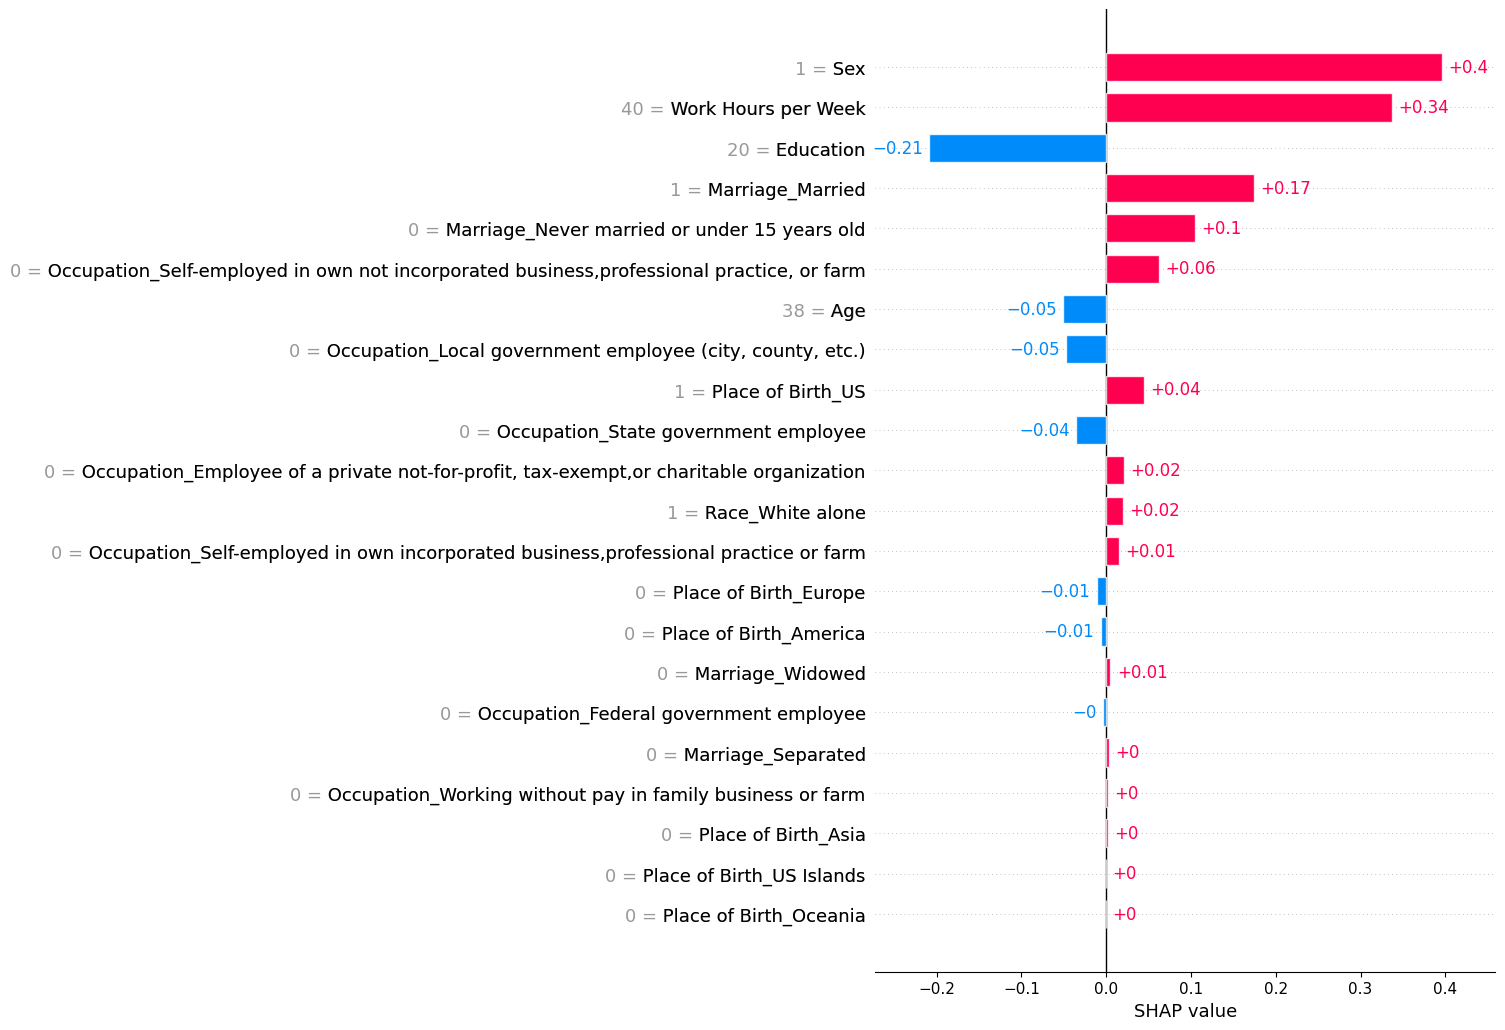

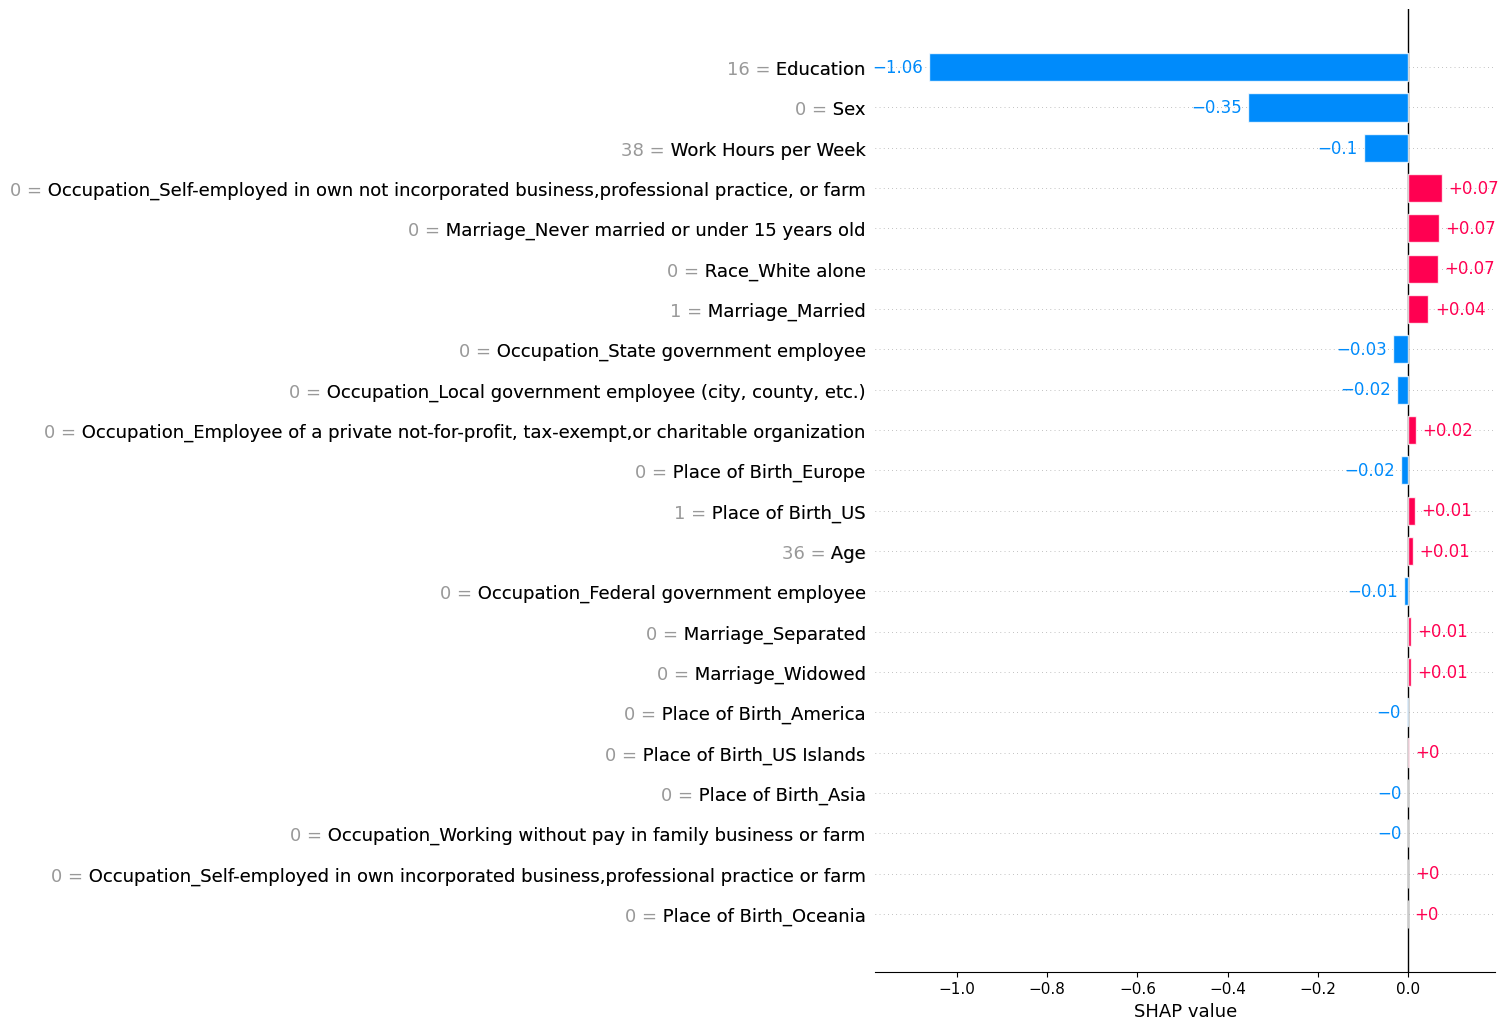

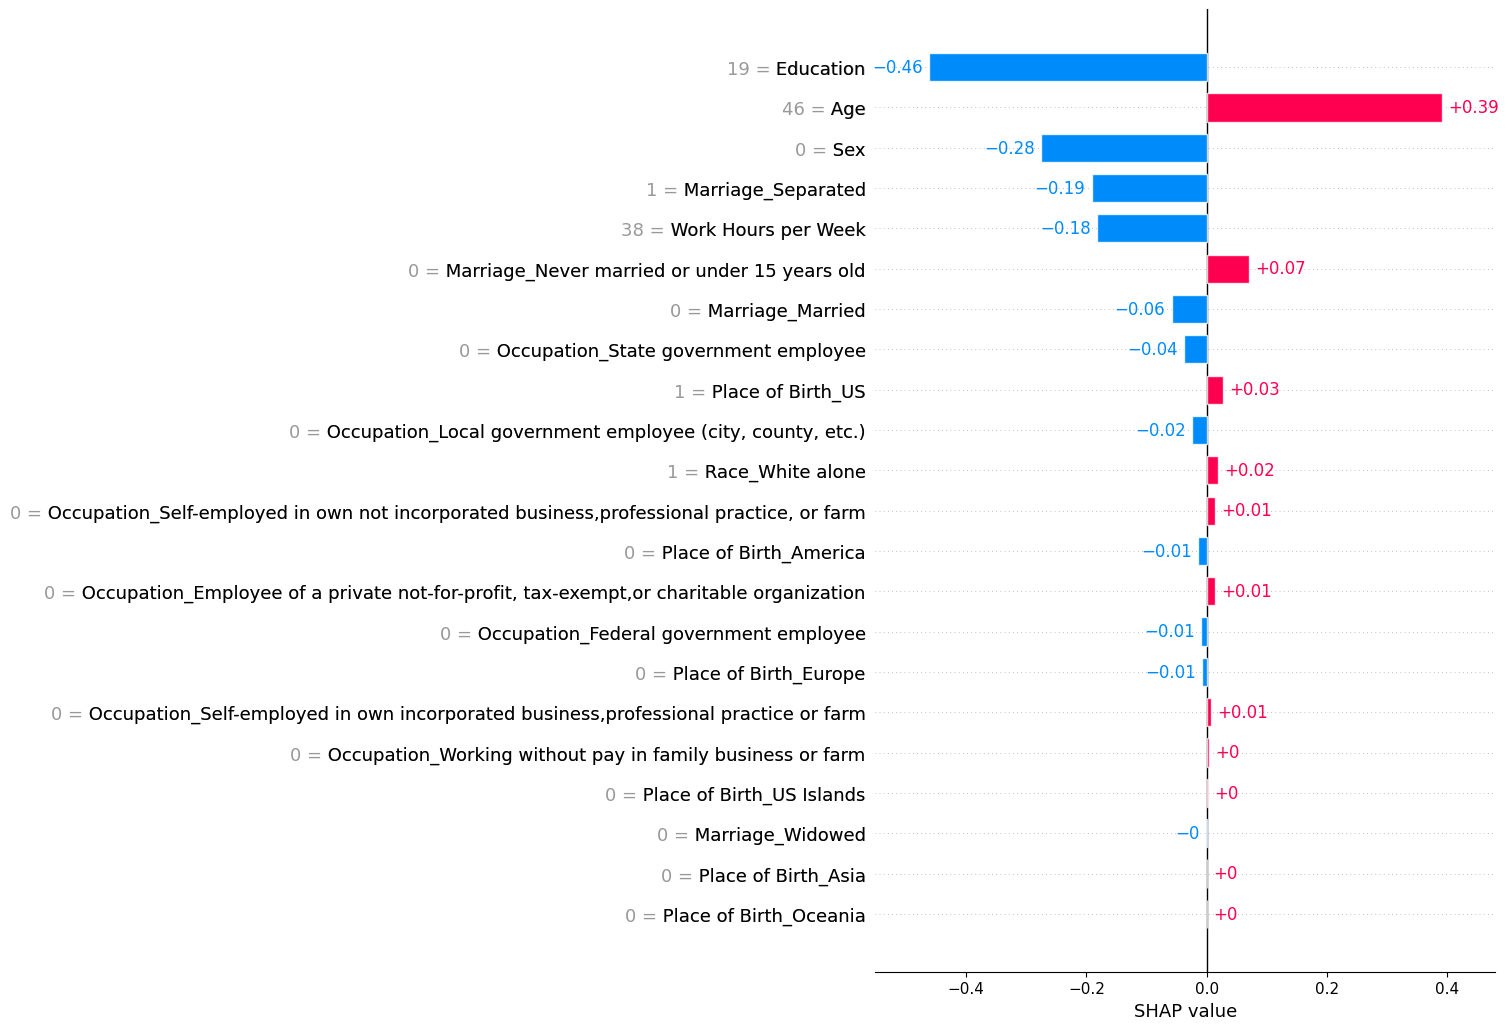

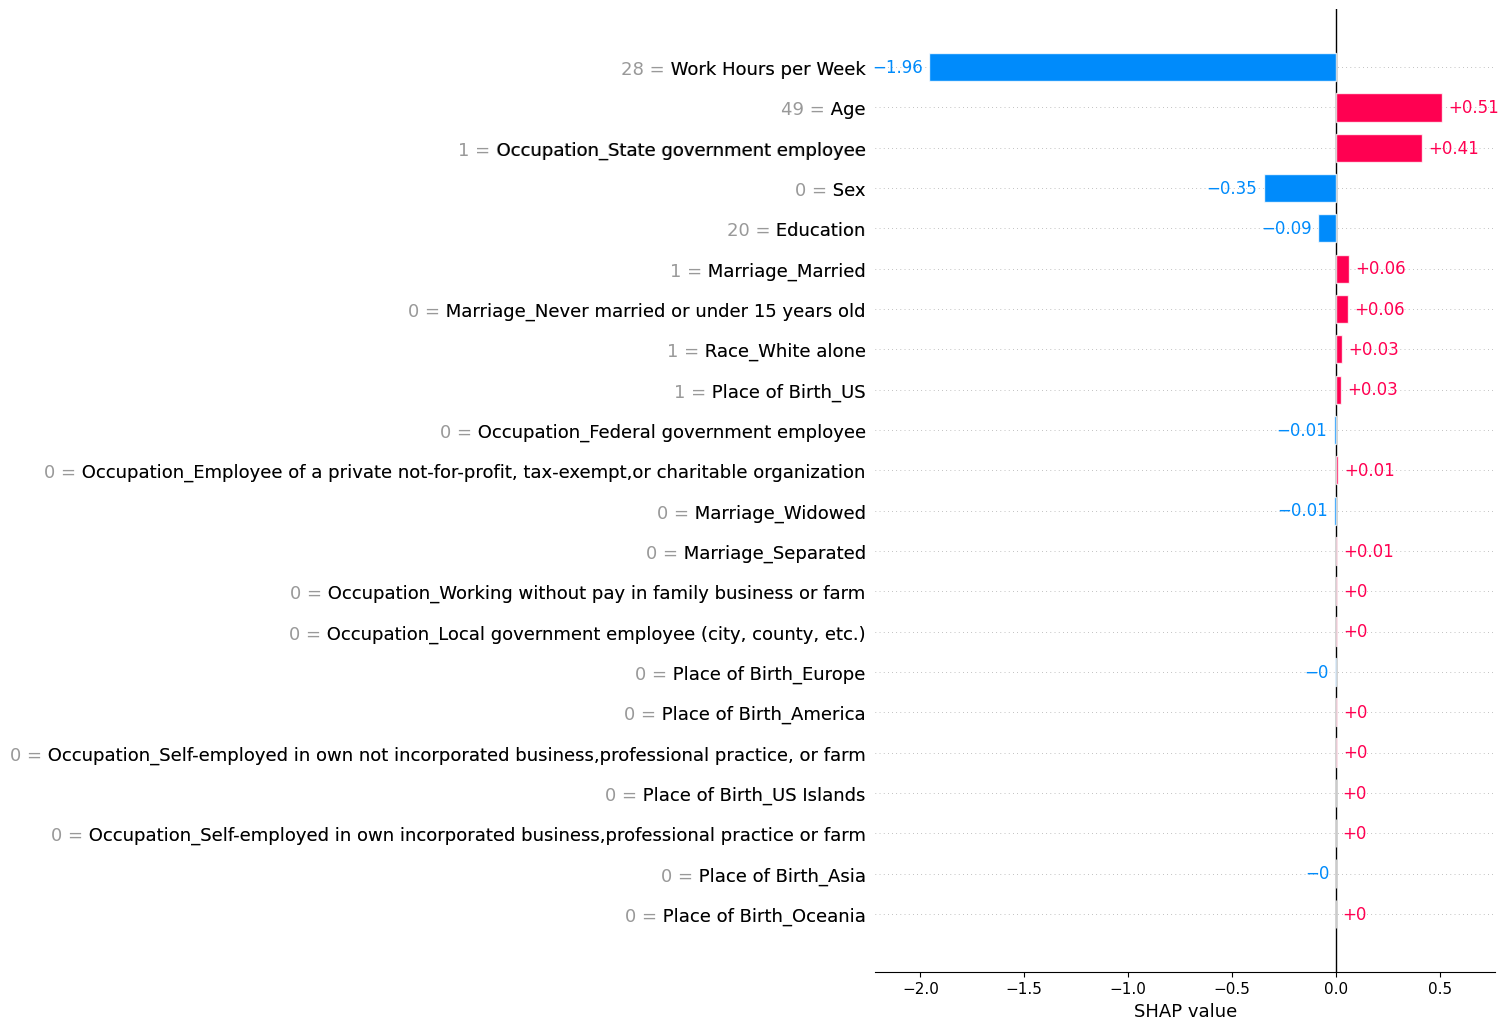

In [38]:
for i in cut5_top4_idx:
    shap.plots.bar(base_result['shap_vals'][0][i],max_display=22)

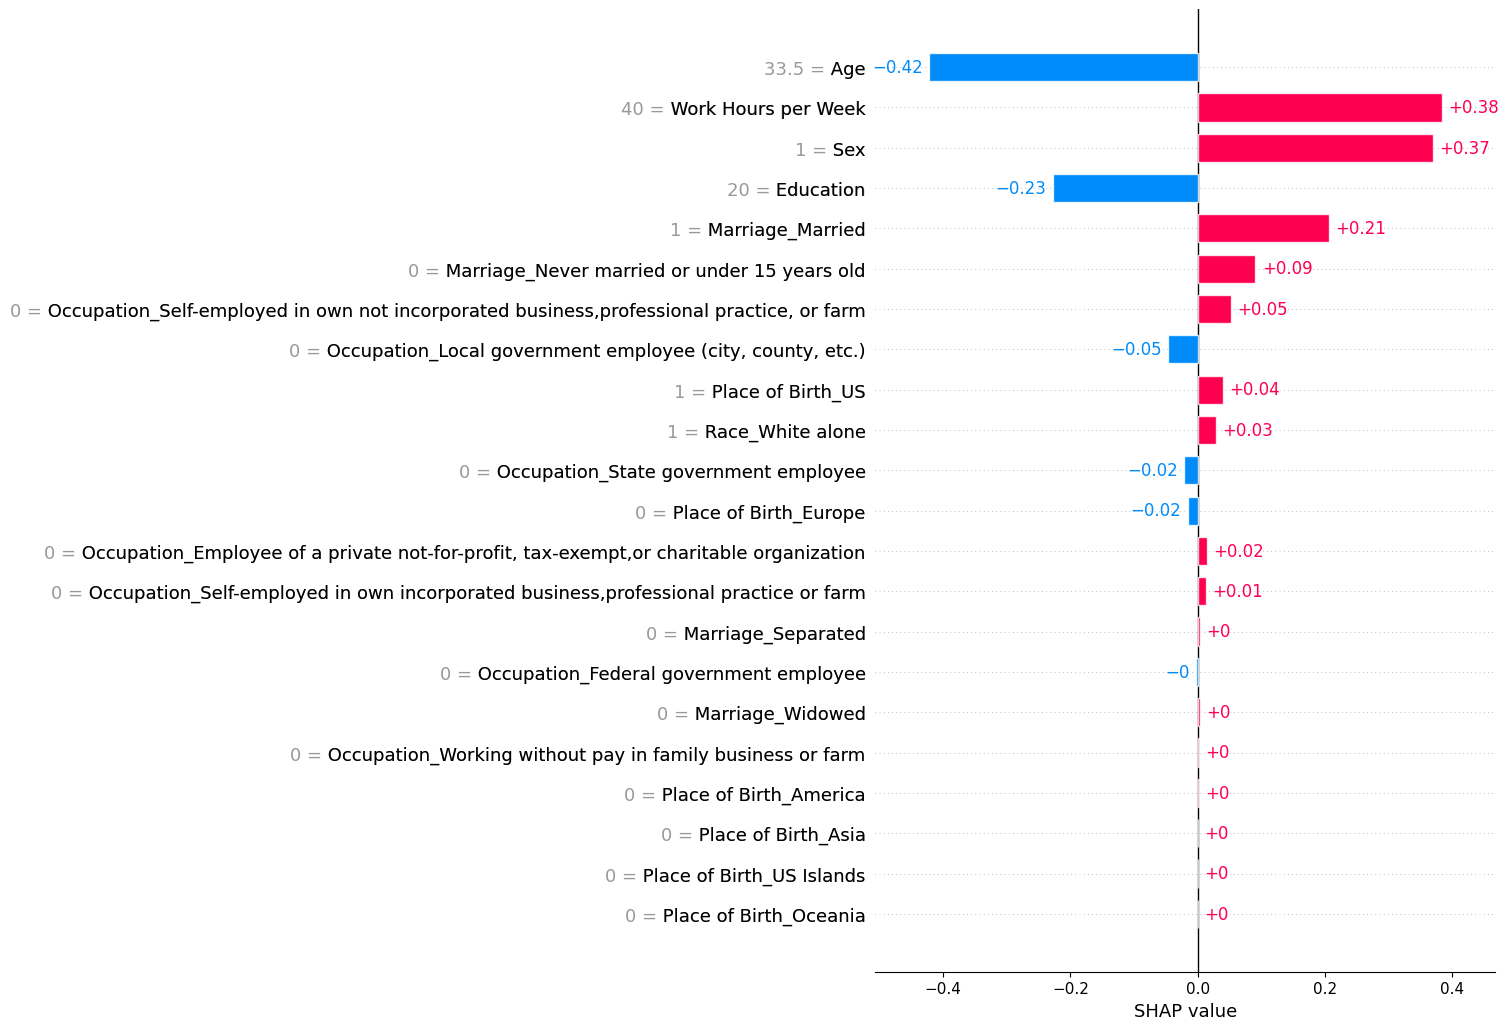

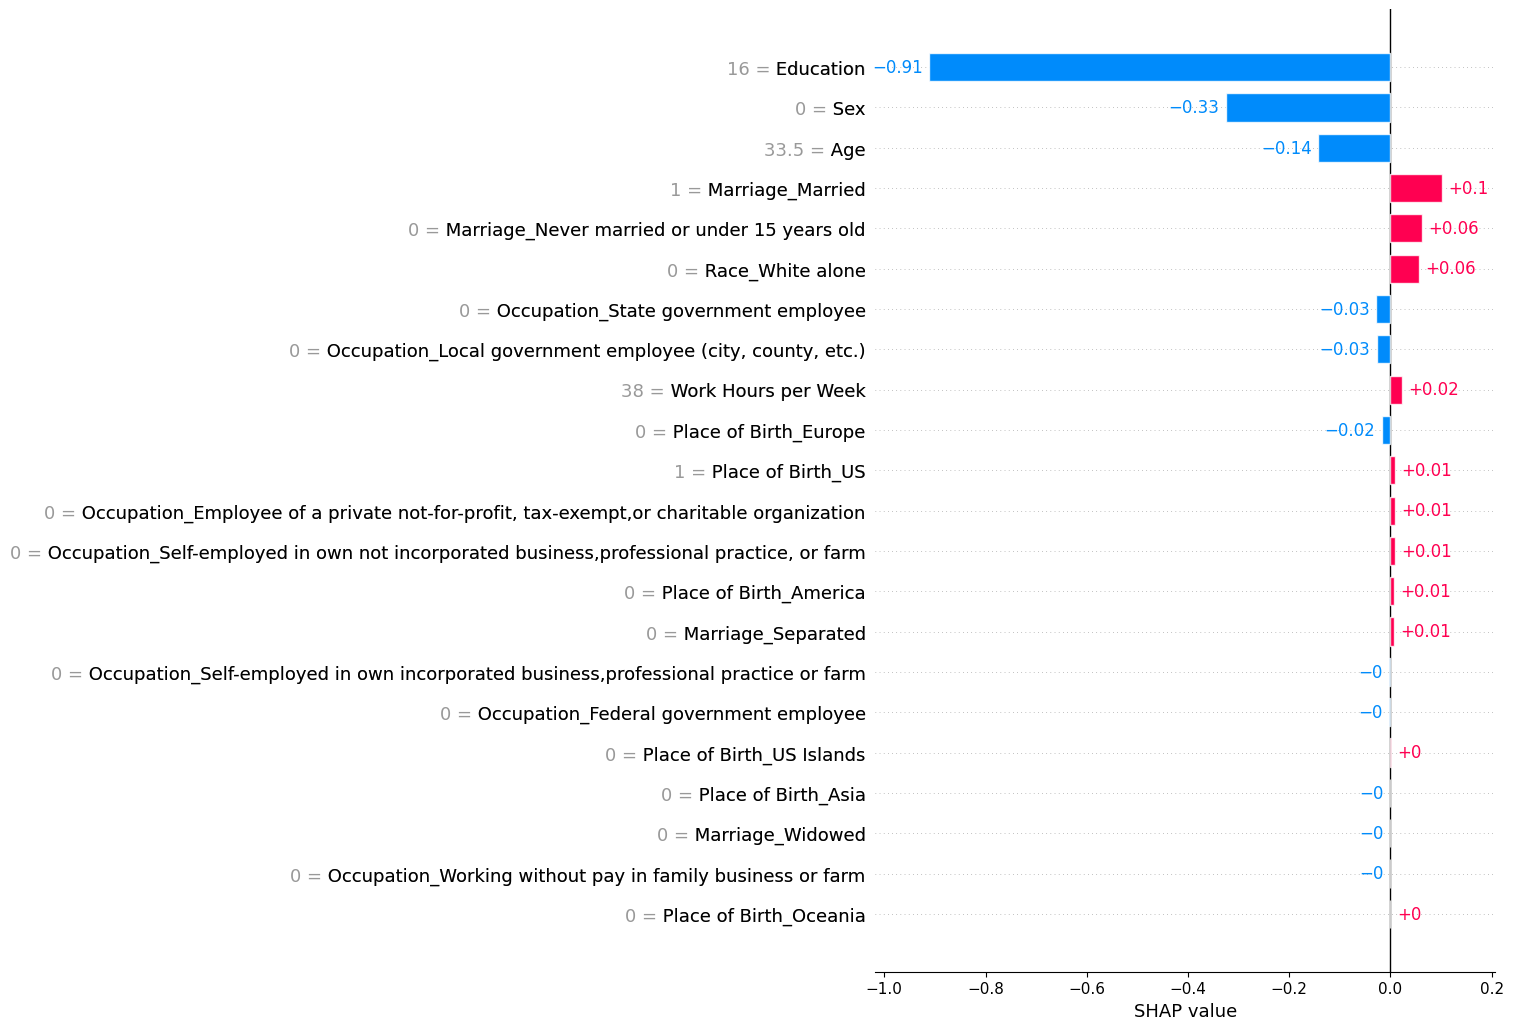

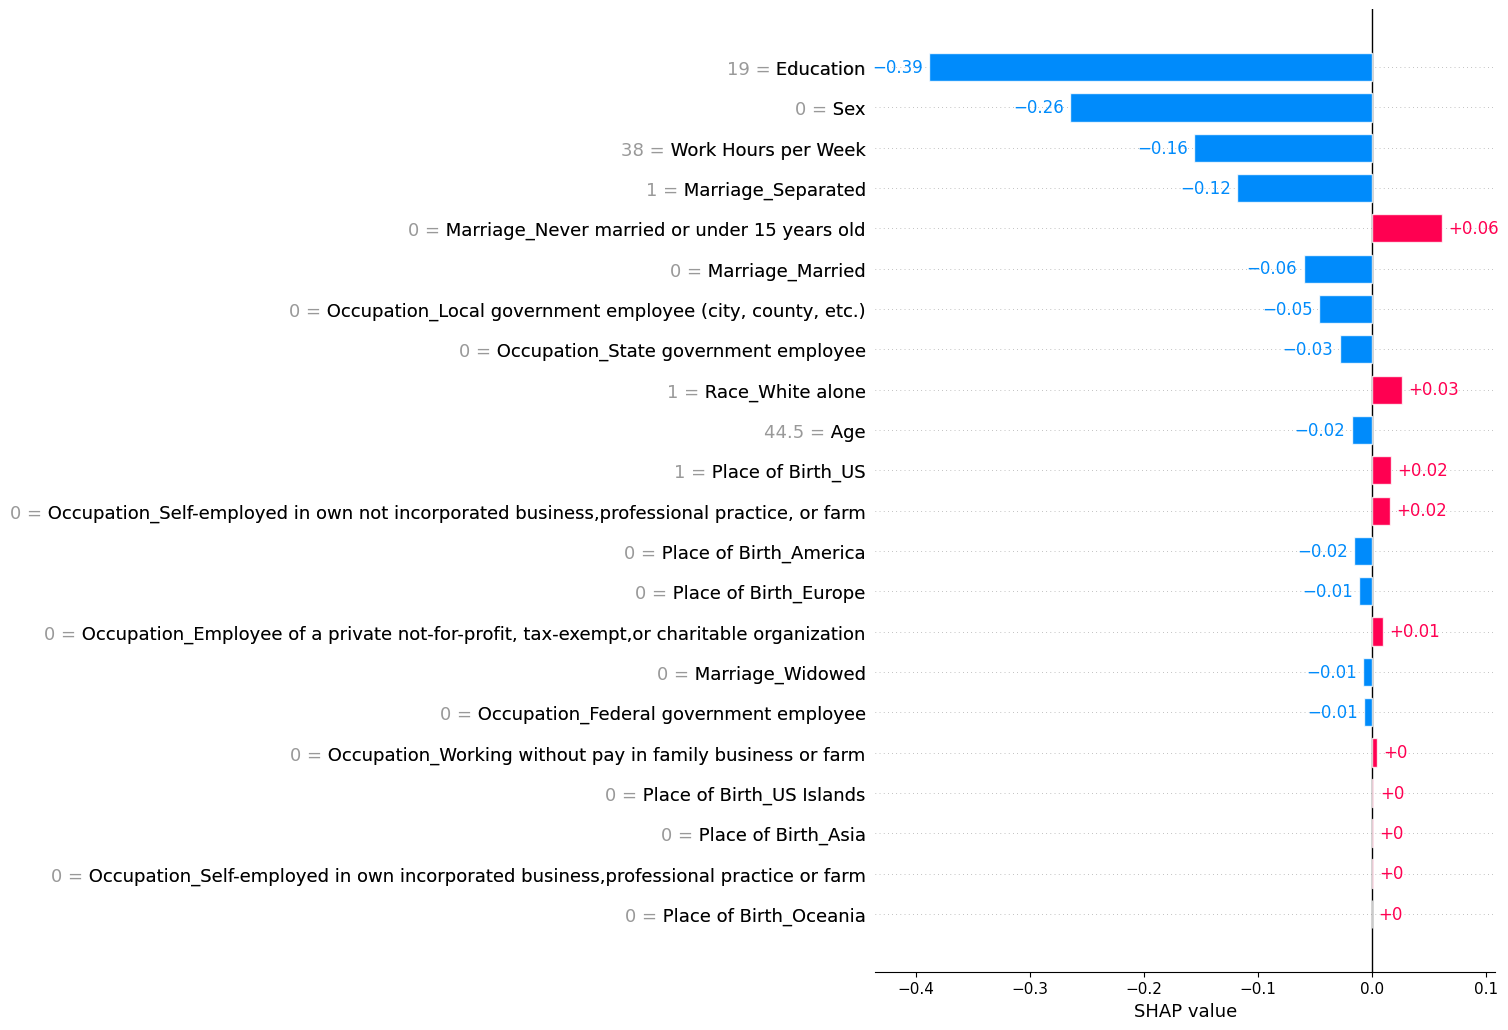

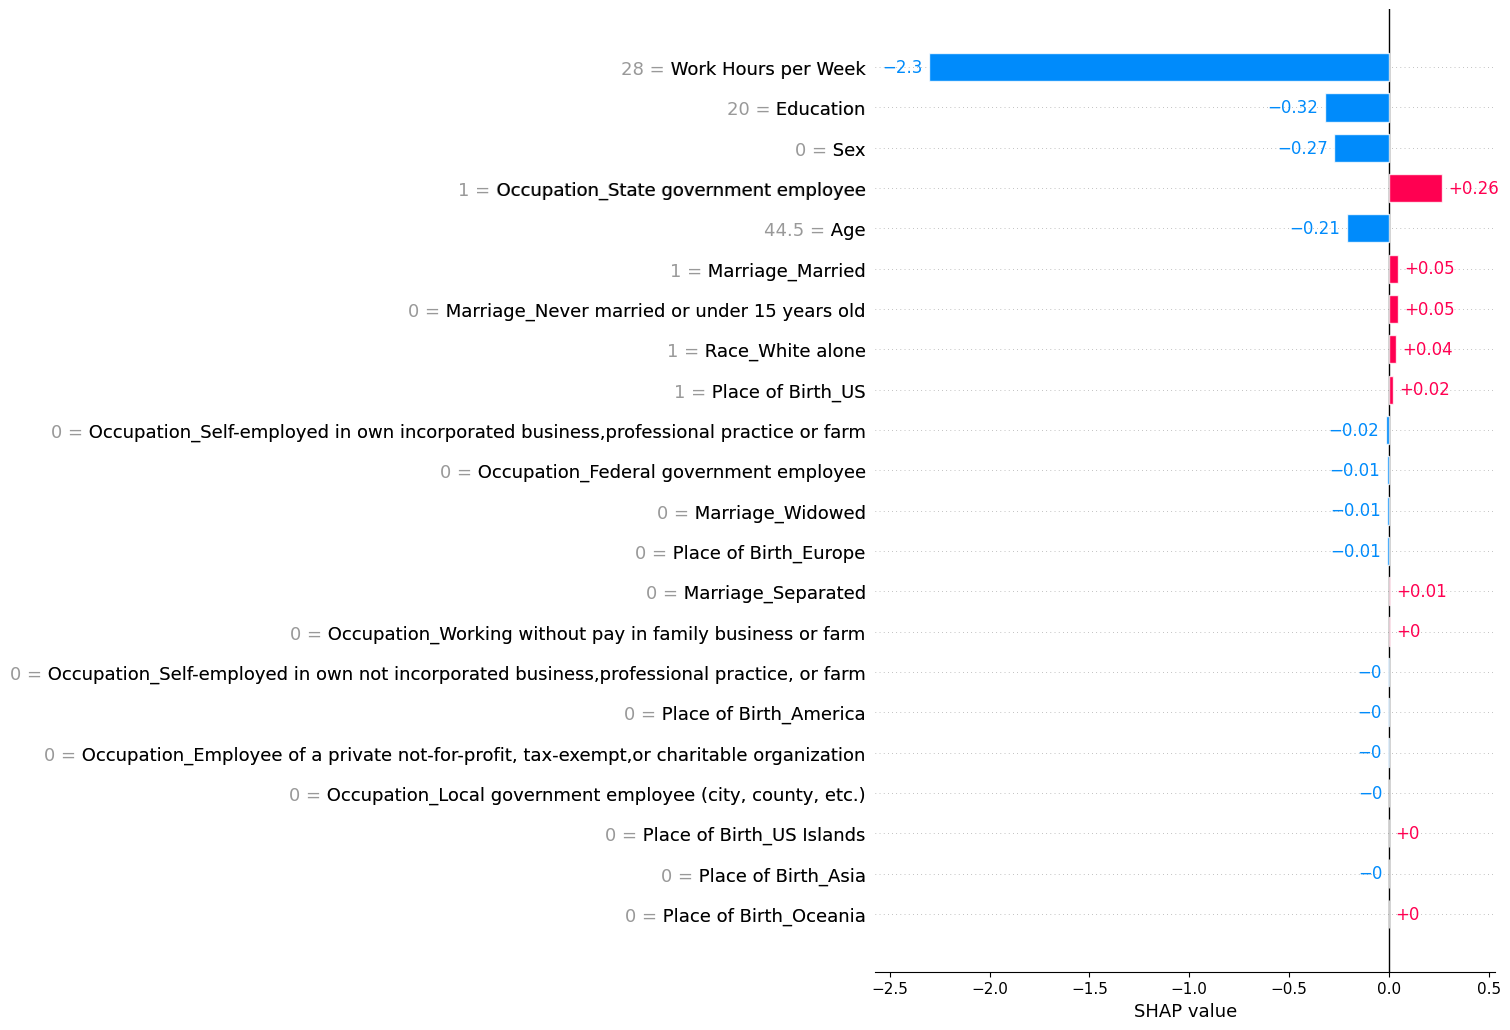

In [39]:
for i in cut5_top4_idx:
    shap.plots.bar(cut5_result['shap_vals'][0][i],max_display=22)

<ErrorbarContainer object of 3 artists>

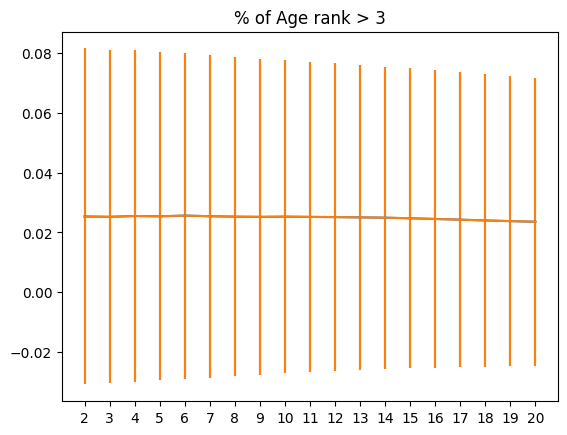

In [186]:
means = [m for m,s in ed_bucket_downs]
stds = [s for m,s in ed_bucket_downs]

means2 = [m for m,s in ew_bucket_downs]
stds2 = [s for m,s in ew_bucket_downs]
plt.xticks(range(1,21))
plt.errorbar(list(range(2,21)), means, stds)
plt.title('% of Age rank > 3')


plt.title('% of Age rank > 3')
plt.xticks(range(2,21))
plt.errorbar(list(range(2,21)), means, stds)

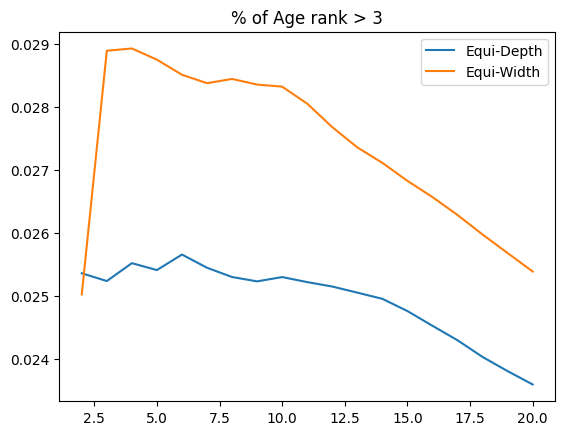

In [187]:
plt.title('% of Age rank > 3')
plt.plot(range(2,21),means,label='Equi-Depth')
plt.plot(range(2,21),means2, label='Equi-Width')
plt.legend()

Text(0.5, 1.0, '% of Age rank > 3')

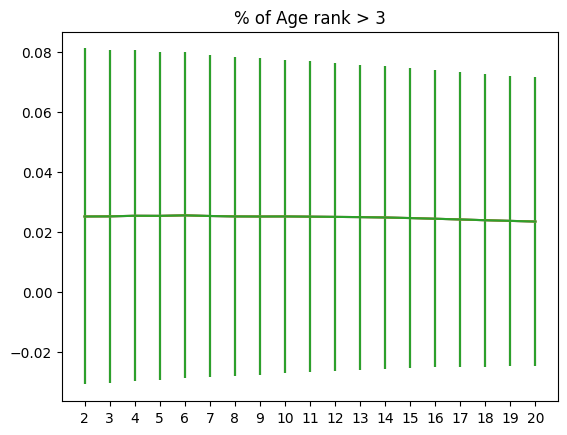

In [188]:
# plt.plot(ed_bucket_tn_downs)
means = [m for m,s in ed_bucket_tn_downs]
stds = [s for m,s in ed_bucket_tn_downs]

means2 = [m for m,s in ew_bucket_tn_downs]
stds2 = [s for m,s in ew_bucket_tn_downs]
plt.xticks(range(1,21))
plt.errorbar(list(range(2,21)), means, stds)
plt.title('% of Age rank > 3')


plt.title('% of Age rank > 3')
plt.xticks(range(2,21))
plt.errorbar(list(range(2,21)), means, stds)

plt.xticks(range(1,21))
plt.errorbar(list(range(2,21)), means, stds)
plt.title('% of Age rank > 3')

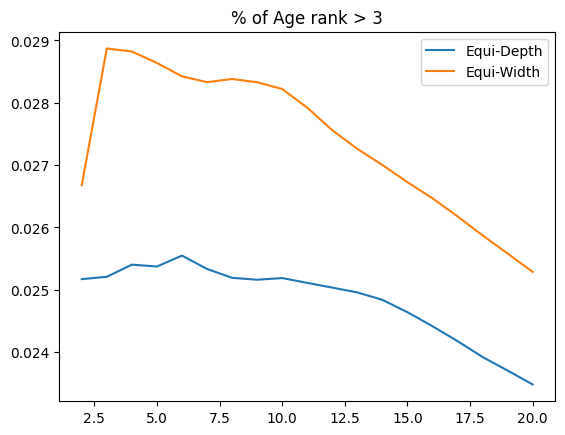

In [189]:
plt.title('% of Age rank > 3')
plt.plot(range(2,21),means,label='Equi-Depth')
plt.plot(range(2,21),means2, label='Equi-Width')
plt.legend()

Text(0.5, 1.0, '% of Age rank > 3')

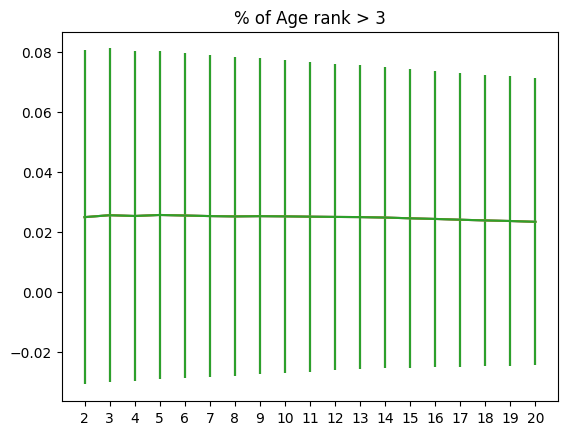

In [190]:
# plt.plot(ed_bucket_tn_downs)
means = [m for m,s in ed_bucket_fn_downs]
stds = [s for m,s in ed_bucket_fn_downs]

means2 = [m for m,s in ew_bucket_fn_downs]
stds2 = [s for m,s in ew_bucket_fn_downs]
plt.xticks(range(1,21))
plt.errorbar(list(range(2,21)), means, stds)
plt.title('% of Age rank > 3')


plt.title('% of Age rank > 3')
plt.xticks(range(2,21))
plt.errorbar(list(range(2,21)), means, stds)

plt.xticks(range(1,21))
plt.errorbar(list(range(2,21)), means, stds)
plt.title('% of Age rank > 3')

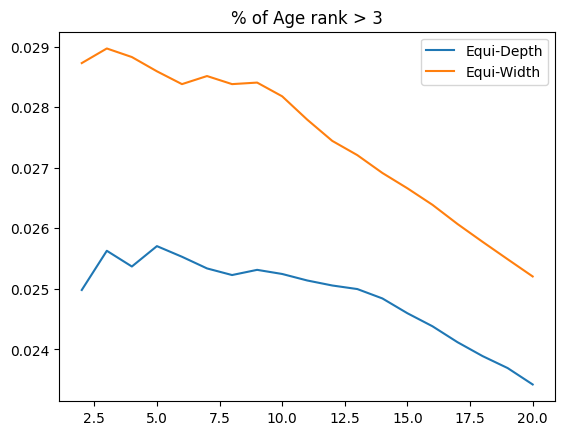

In [191]:
plt.title('% of Age rank > 3')
plt.plot(range(2,21),means,label='Equi-Depth')
plt.plot(range(2,21),means2, label='Equi-Width')
plt.legend()

In [146]:
len(means

[np.float64(0.025360178424523473),
 np.float64(0.02523660595244904),
 np.float64(0.025520569614762297),
 np.float64(0.025410671815232856),
 np.float64(0.025657280844378377),
 np.float64(0.025447578300725995),
 np.float64(0.025300384998523894),
 np.float64(0.025231409558944116),
 np.float64(0.02529991420859872),
 np.float64(0.025219711426535826),
 np.float64(0.02514941824144913),
 np.float64(0.02505262143311544),
 np.float64(0.024954296158886065),
 np.float64(0.024760188131373918),
 np.float64(0.02452624831139191),
 np.float64(0.024296530088220268),
 np.float64(0.02403149211047119),
 np.float64(0.02380652756307287),
 np.float64(0.023594736168368668)]

<ErrorbarContainer object of 3 artists>

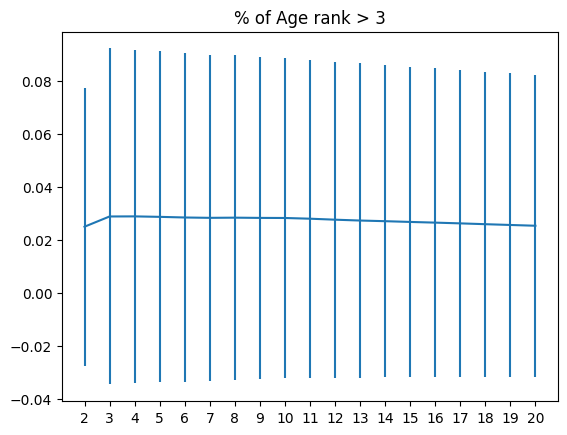

In [147]:
means = [m for m,s in ew_bucket_downs]
stds = [s for m,s in ew_bucket_downs]
plt.title('% of Age rank > 3')
plt.xticks(range(1,21))
plt.errorbar(list(range(2,21)), means, stds)

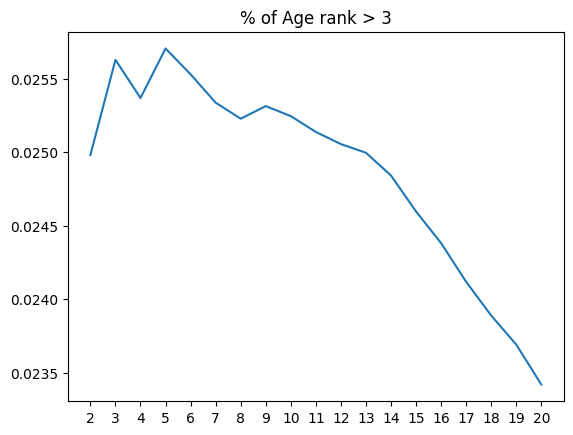

In [173]:
plt.title('% of Age rank > 3')
plt.xticks(list(range(2,21)))
plt.plot(range(2,21),means,)

In [152]:
means[0]

np.float64(0.02502355371177878)

Text(0.5, 1.0, '% of Age rank > 3')

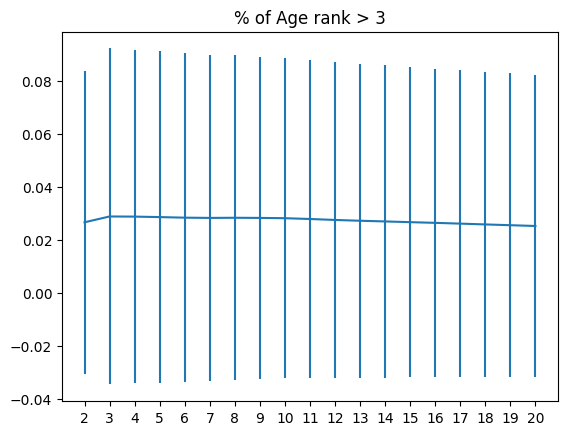

In [178]:
# plt.plot(ed_bucket_tn_downs)
means = [m for m,s in ew_bucket_tn_downs]
stds = [s for m,s in ew_bucket_tn_downs]
plt.xticks(range(1,21))
plt.errorbar(list(range(2,21)), means, stds)
plt.title('% of Age rank > 3')

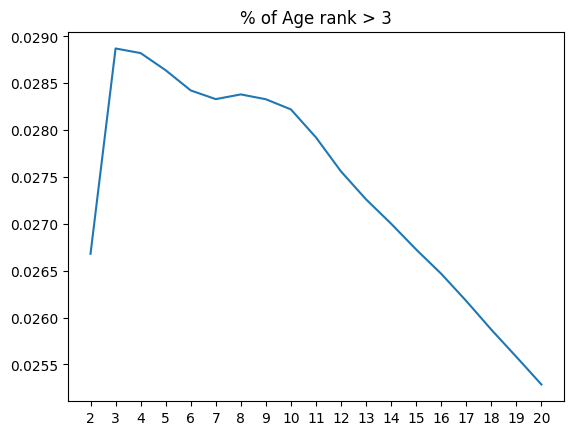

In [179]:
plt.title('% of Age rank > 3')
plt.xticks(list(range(2,21)))
plt.plot(range(2,21),means,)

<ErrorbarContainer object of 3 artists>

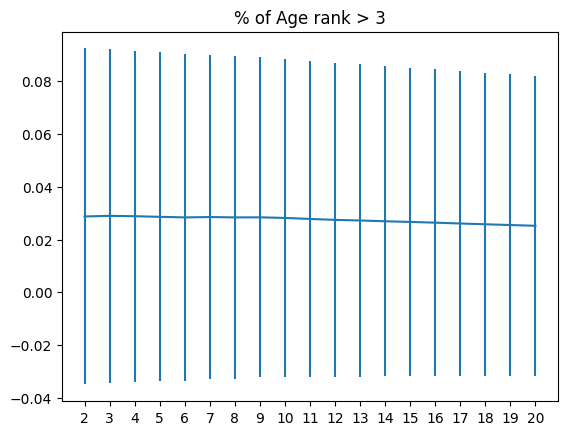

In [176]:
means = [m for m,s in ew_bucket_fn_downs]
stds = [s for m,s in ew_bucket_fn_downs]
plt.xticks(range(1,21))
plt.title('% of Age rank > 3')
plt.errorbar(list(range(2,21)), means, stds)

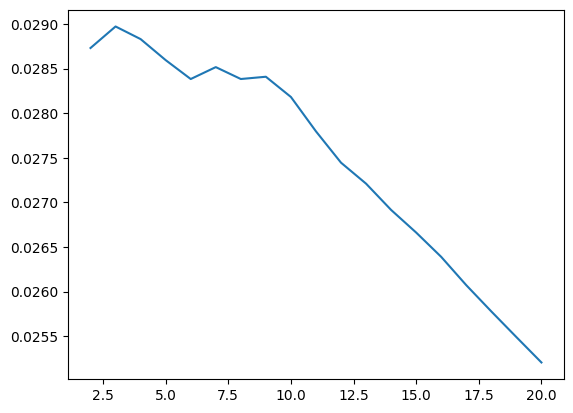

In [177]:
plt.plot(range(2,21),means,)